In [ ]:
!pip install gdown
!pip install orange3

     |████████████████████████████████| 25.3MB 1.8MB/s 
     |████████████████████████████████| 491kB 40.5MB/s 
     |████████████████████████████████| 235kB 49.6MB/s 
     |████████████████████████████████| 8.3MB 35.6MB/s 
     |████████████████████████████████| 71kB 9.2MB/s 
     |████████████████████████████████| 2.3MB 35.6MB/s 
     |████████████████████████████████| 51kB 6.7MB/s 
     |████████████████████████████████| 256kB 52.4MB/s 
     |████████████████████████████████| 942kB 27.2MB/s 
     |████████████████████████████████| 153kB 43.4MB/s 
     |████████████████████████████████| 51kB 6.8MB/s 
     |████████████████████████████████| 67.5MB 54kB/s 
     |████████████████████████████████| 317kB 43.1MB/s 
     |████████████████████████████████| 59.9MB 73kB/s 
     |████████████████████████████████| 61kB 8.1MB/s 
     |████████████████████████████████| 51kB 7.8MB/s 
     |████████████████████████████████| 61kB 9.1MB/s 
     |████████████████████████████████| 3.2MB 30.0MB/s 
  Crea

In [ ]:
!gdown https://drive.google.com/uc?id=1MvPjY4m58TW51NZbUIl5tRJbERKMnIk7 -O pathmnist.npz
!gdown https://drive.google.com/uc?id=146WDl2VzVdLhnJl5JqYqKVyDPlDQoLDl -O octmnist.npz
!gdown https://drive.google.com/uc?id=1BIJFOn5ivB766qNIZdI2Owt8GAmpsmic -O organmnist_axial.npz

Downloading...
From: https://drive.google.com/uc?id=1MvPjY4m58TW51NZbUIl5tRJbERKMnIk7
To: /content/pathmnist.npz
206MB [00:08, 25.4MB/s]
Downloading...
From: https://drive.google.com/uc?id=146WDl2VzVdLhnJl5JqYqKVyDPlDQoLDl
To: /content/octmnist.npz
54.9MB [00:03, 16.1MB/s]
Downloading...
From: https://drive.google.com/uc?id=1BIJFOn5ivB766qNIZdI2Owt8GAmpsmic
To: /content/organmnist_axial.npz
38.2MB [00:02, 16.5MB/s]


In [ ]:
from tensorflow.keras import callbacks, optimizers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import backend as K
from tensorflow.keras.applications import InceptionV3, ResNet50V2, EfficientNetB1, DenseNet169
from tensorflow.keras import models, layers, optimizers
from tensorflow.keras.layers import Dense, Flatten, Dropout, Lambda, Input
from tensorflow.image import resize
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from Orange.evaluation import compute_CD, graph_ranks
from scipy.stats import friedmanchisquare, rankdata
import numpy as np
import pandas as pd
import tensorflow as tf
import re, os, time, requests
import matplotlib.pyplot as plt

In [ ]:
DATASETS = {
    'pathmnist': {
        'shape': (28, 28, 3),
        'classes': 9,
        'proposal': '2(Conv ),(Conv ),(Conv ),(MaxPool Dropout),(Flatten),(Fc 1 128 Dropout),(Lr 0.001)',
    },
    'octmnist': {
        'shape': (28, 28, 1),
        'classes': 4,
        'proposal': '3(Conv ),(Conv ),(Conv BNorm),(MaxPool Dropout),(Flatten),(Fc 1 64 Dropout),(Lr 0.001)',
    },
    'organmnist_axial': {
        'shape': (28, 28, 1),
        'classes': 11,
        'proposal': '3(Conv BNorm),(Conv ),(MaxPool Dropout),(Flatten),(Fc 1 64 Dropout),(Lr 0.0001)',
    },
}
CNNS = ['Proposal', 'InceptionV3', 'ResNet50V2', 'EfficientNetB1', 'DenseNet169']
NUM_SAMPLES = 10
METRICS_URL = 'https://papermetrics.herokuapp.com/api/analysis/'

In [ ]:
def load_dataset(dataset_name):

  shape = DATASETS[dataset_name]['shape']
  dataset = np.load('%s.npz' % dataset_name)

  train_images = dataset['train_images']
  validation_images = dataset['val_images']
  test_images = dataset['test_images']
  train_labels = dataset['train_labels']
  validation_labels = dataset['val_labels']
  test_labels = dataset['test_labels']

  if shape[2] == 1:
    train_images = train_images.reshape((train_images.shape[0], 28, 28, 1))
    validation_images = validation_images.reshape((validation_images.shape[0], 28, 28, 1))
    test_images = test_images.reshape((test_images.shape[0], 28, 28, 1))

  train_images = train_images.astype("float") / 255.0
  test_images = test_images.astype("float") / 255.0
  validation_images = validation_images.astype("float") / 255.0

  lb = LabelBinarizer()
  train_labels = lb.fit_transform(train_labels)
  validation_labels = lb.transform(validation_labels)
  test_labels = lb.transform(test_labels)

  dataset.close()

  return train_images, train_labels, validation_images, validation_labels, test_images, test_labels

In [ ]:
def f1_score(y_true, y_pred):
  
  true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
  possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
  predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
  precision = true_positives / (predicted_positives + K.epsilon())
  recall = true_positives / (possible_positives + K.epsilon())
  f1_val = 2 * (precision * recall) / (precision + recall + K.epsilon())
  return f1_val

In [ ]:
def build_proposal_model(dataset):

  phenotype = DATASETS[dataset]['proposal']

  model = models.Sequential()

  filter_size = 32
  nconvs = 0
  optimizer = None

  model.add(layers.InputLayer(input_shape=DATASETS[dataset]['shape']))

  nblocks = int(phenotype[0])

  for n in range(nblocks):

      for block in phenotype.split(','):
          
          if 'Conv' in block:

              if nconvs == 2:
                  filter_size *= 2
                  nconvs = 0

              model.add(layers.Conv2D(filter_size, (3, 3), activation='relu', padding='same'))

              if 'BNorm' in block:
                  model.add(layers.BatchNormalization())

              nconvs += 1
          
          if 'MaxPool' in block:
              model.add(layers.MaxPooling2D(pool_size=(2, 2)))
              
              if 'Dropout' in block:
                  model.add(layers.Dropout(0.25))


  for block in phenotype.split(','):

      if 'Flatten' in block:
          model.add(layers.Flatten())

      if 'Fc' in block:
          
          nfc, neurons = re.findall('\d+', block)

          for n in range(int(nfc)):
              model.add(layers.Dense(int(neurons)))
              model.add(layers.Activation('relu'))

          if 'Dropout' in block:
              model.add(layers.Dropout(0.5))

      if 'Lr' in block:
          args = re.findall('\d+\.\d+', block)
          optimizer = optimizers.Adam(learning_rate=float(args[0]))

  model.add(layers.Dense(DATASETS[dataset]['classes'], activation='softmax'))

  return model

In [ ]:
def build_cnn_model(dataset, cnn):

  model = None
  # 75x75 eh o tamanho minimo que as redes disponiveis no Keras aceitam.
  img_w = 75
  img_h = 75
  input = Input(shape=DATASETS[dataset]['shape'])
  resized_images = Lambda(lambda image: resize(image, (img_w, img_h)))(input)

  params = {
      'include_top': True, 
      'weights': None, 
      'classes': DATASETS[dataset]['classes'], 
      'input_tensor': resized_images, 
      'input_shape': (img_w, img_h, DATASETS[dataset]['shape'][2])
  }

  if 'Inception' in cnn:
    model = InceptionV3(**params)
  elif 'ResNet' in cnn:
    model = ResNet50V2(**params)
  elif 'EfficientNet' in cnn:
    model = EfficientNetB1(**params)
  elif 'DenseNet' in cnn:
    model = DenseNet169(**params)

  return model

In [ ]:
def train_model(model, dataset):

  train_images, train_labels, validation_images, \
    validation_labels, test_images, test_labels = load_dataset(dataset)

  batch_size = 128
  epochs = 100

  train_ds = tf.data.Dataset.from_tensor_slices((train_images, train_labels)).batch(batch_size, drop_remainder=True)
  validation_ds = tf.data.Dataset.from_tensor_slices((validation_images, validation_labels)).batch(batch_size, drop_remainder=True)

  history = model.fit(train_ds,
          epochs=epochs, 
          validation_data=validation_ds,
          verbose=1)

  loss, accuracy, f1score = model.evaluate(test_images, test_labels, verbose=1)

  print(accuracy, f1score)

  return accuracy, f1score

In [ ]:
tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

In [ ]:
for dataset in DATASETS:

  for cnn in CNNS:

    while True:

      r = requests.get(METRICS_URL)
      df = pd.DataFrame.from_records(r.json())

      print('Verificando dataset e cnn:', dataset, cnn)

      total = len(df[(df.dataset == dataset) & (df.cnn == cnn)])
      remain = NUM_SAMPLES - total

      if remain <= 0:
        break
      else:
        print('Ainda faltam amostras. Montando modelo.')

        with tpu_strategy.scope():
          if 'Proposal' in cnn:
            model = build_proposal_model(dataset)
          else:
            model = build_cnn_model(dataset, cnn)

        model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy', f1_score])
        # model.summary()

        print('Iniciando treinamento...')

        start_time = time.time()

        accuracy, f1score = train_model(model, dataset)

        end_time = round(time.time() - start_time)

        model_name = '%s-%s.h5' % (dataset, cnn)
        model.save(model_name)
        size = os.path.getsize(model_name)

        data = {
            'dataset': dataset,
            'cnn': cnn,
            'accuracy': accuracy,
            'f1_score': f1score,
            'size': size,
            'num_layers': len(model.layers),
            'num_params': model.count_params(),
            'time': end_time,
        }
          
        print(data)

        r = requests.post(METRICS_URL, json=data)

Verificando dataset e cnn: pathmnist Proposal
Verificando dataset e cnn: pathmnist InceptionV3
Verificando dataset e cnn: pathmnist ResNet50V2
Verificando dataset e cnn: pathmnist EfficientNetB1
Verificando dataset e cnn: pathmnist DenseNet169
Verificando dataset e cnn: octmnist Proposal
Verificando dataset e cnn: octmnist InceptionV3
Verificando dataset e cnn: octmnist ResNet50V2
Verificando dataset e cnn: octmnist EfficientNetB1
Verificando dataset e cnn: octmnist DenseNet169
Verificando dataset e cnn: organmnist_axial Proposal
Verificando dataset e cnn: organmnist_axial InceptionV3
Verificando dataset e cnn: organmnist_axial ResNet50V2
Verificando dataset e cnn: organmnist_axial EfficientNetB1
Verificando dataset e cnn: organmnist_axial DenseNet169


In [ ]:
r = requests.get(METRICS_URL)
 
df = pd.DataFrame.from_records(r.json())
df[['accuracy', 'f1_score']] = df[['accuracy', 'f1_score']].astype(float)
df[['size', 'num_layers', 'num_params', 'time']] = df[['size', 'num_layers', 'num_params', 'time']].astype(float).astype(int)
df['size'] = df['size']/(1024*1024)
 
df.groupby(['dataset', 'cnn']).agg([np.mean, np.std])

accuracy            ...    time            
                                     mean       std  ...    mean         std
dataset          cnn                                 ...                    
octmnist         DenseNet169     0.765200  0.030404  ...  6129.1  116.981907
                 EfficientNetB1  0.744800  0.013096  ...  3699.4   58.208819
                 InceptionV3     0.727400  0.018100  ...  4223.2  113.965687
                 Proposal        0.753000  0.017391  ...  1446.0   54.723548
                 ResNet50V2      0.744500  0.021920  ...  3057.8   77.889951
organmnist_axial DenseNet169     0.937411  0.002623  ...  2363.9   99.137895
                 EfficientNetB1  0.906227  0.020544  ...  1567.1   12.999573
                 InceptionV3     0.910513  0.028641  ...  1728.7   39.640187
                 Proposal        0.928232  0.004605  ...   596.8   10.860735
                 ResNet50V2      0.913297  0.056825  ...  1290.0   37.941475
pathmnist        DenseNet169     0.871811  0.018079  ...  6074.6  197.259108
                 EfficientNetB1  0.792618  0.048063  ...  3606.0   85.140407
                 InceptionV3     0.856379  0.043155  ...  3892.9   47.871239
                 Proposal        0.902326  0.010196  ...  1332.9   57.089501
                 ResNet50V2      0.762981  0.130026  ...  3002.3  124.476727

[15 rows x 12 columns]

Null hypothesis: The means of the results of two or more algorithms are the same.
Dataset, objective: pathmnist accuracy
	 null hypothesis: rejected
	 p-value: 9.39989958110991e-07
	 ranking: [4.4 1.  2.6 4.6 2.4]
	 names: ['ResNet50V2', 'Proposal', 'InceptionV3', 'EfficientNetB1', 'DenseNet169']
	 cd: 1.9288274929443536


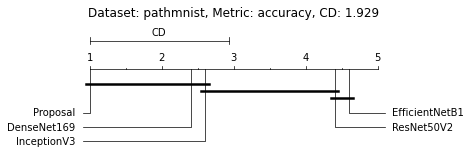

Dataset, objective: pathmnist f1_score
	 null hypothesis: rejected
	 p-value: 9.226628710549054e-07
	 ranking: [4.4 1.  2.6 4.6 2.4]
	 names: ['ResNet50V2', 'Proposal', 'InceptionV3', 'EfficientNetB1', 'DenseNet169']
	 cd: 1.9288274929443536


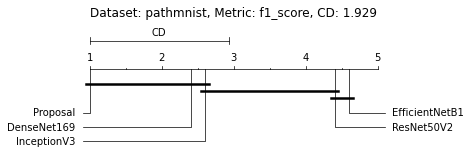

Dataset, objective: octmnist accuracy
	 null hypothesis: rejected
	 p-value: 9.57682867478607e-07
	 ranking: [3.3  2.2  5.   3.35 1.15]
	 names: ['ResNet50V2', 'Proposal', 'InceptionV3', 'EfficientNetB1', 'DenseNet169']
	 cd: 1.9288274929443536


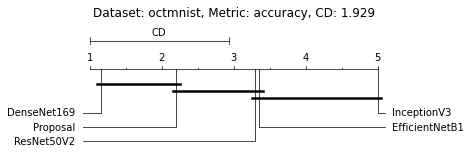

Dataset, objective: octmnist f1_score
	 null hypothesis: rejected
	 p-value: 1.7339111531179656e-06
	 ranking: [3.4 2.1 4.9 3.3 1.3]
	 names: ['ResNet50V2', 'Proposal', 'InceptionV3', 'EfficientNetB1', 'DenseNet169']
	 cd: 1.9288274929443536


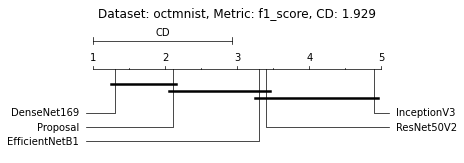

Dataset, objective: organmnist_axial accuracy
	 null hypothesis: rejected
	 p-value: 9.226628710549054e-07
	 ranking: [2.3 2.9 4.  4.8 1. ]
	 names: ['ResNet50V2', 'Proposal', 'InceptionV3', 'EfficientNetB1', 'DenseNet169']
	 cd: 1.9288274929443536


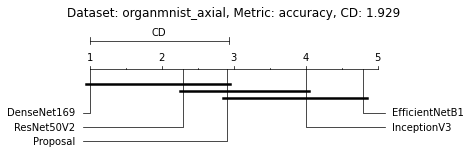

Dataset, objective: organmnist_axial f1_score
	 null hypothesis: rejected
	 p-value: 1.0905100294553414e-06
	 ranking: [2.3 2.9 4.  4.8 1. ]
	 names: ['ResNet50V2', 'Proposal', 'InceptionV3', 'EfficientNetB1', 'DenseNet169']
	 cd: 1.9288274929443536


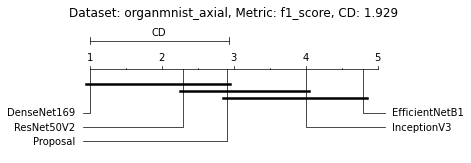

In [ ]:
objectives = ['accuracy', 'f1_score']
alpha = 0.05
 
print('Null hypothesis:', 'The means of the results of two or more algorithms are the same.')

for dataset in DATASETS:
  
  data = df[df.dataset == dataset]
  cnns = data.cnn.unique()
  
  for objective in objectives:
    
    print('Dataset, objective:', dataset, objective)
 
    df1 = pd.DataFrame({cnn: list(data[data.cnn == cnn][objective]) for cnn in cnns})
    values = df1.values
    names = df1.columns    

    friedman = friedmanchisquare(*values)
    ranks = np.array([rankdata(-p) for p in values])
    average_ranks = np.mean(ranks, axis = 0)
    
    cd = compute_CD(average_ranks, n=len(df1), alpha=str(alpha), test='nemenyi')
    
    print('\t', 'null hypothesis:', 'rejected' if friedman.pvalue < alpha else 'accepted')
    print('\t', 'p-value:', friedman.pvalue)
    print('\t', 'ranking:', average_ranks)
    print('\t', 'names:', list(names))
    print('\t', 'cd:', cd)
    
    graph_ranks(average_ranks, names=names, cd=cd)
    # title = f'Friedman-Nemenyi (CD = {round(cd, 3)})'
    title = f'Dataset: {dataset}, Metric: {objective}, CD: {round(cd, 3)}'
    plt.title(title)
    plt.savefig(f'/content/cd_{dataset}_{objective}.pdf', bbox_inches='tight')
    plt.show()


In [ ]:
!tar -cvzf plots.tar.gz /content/*.pdf

tar: Removing leading `/' from member names
/content/cd_octmnist_accuracy.pdf
/content/cd_octmnist_f1_score.pdf
/content/cd_organmnist_axial_accuracy.pdf
/content/cd_organmnist_axial_f1_score.pdf
/content/cd_pathmnist_accuracy.pdf
/content/cd_pathmnist_f1_score.pdf
